### ----- Import Requirements -----

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### ----- Define Functions -----

In [2]:
# five allocation models

#last touchpoint
def find_last_touchpoint(t_row, touch_col_prepend_f, max_touches_f):
    for t in range(max_touches_f, 0, -1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str):
                return t_val
        except:
            None
    return None

# first touchpoint
def find_first_touchpoint(t_row, touch_col_prepend_f, max_touches_f):
    for t in range(1, max_touches_f + 1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str):
                return t_val
        except:
            None
    return None

#last non-direct touch point
def find_last_nondirect_touchpoint(t_row, touch_col_prepend_f, max_touches_f, direct_label_f):
    for t in range(max_touches_f, 0, -1):
        t_val = t_row[touch_col_prepend_f + str(t)]
        try:
            if isinstance(t_val, str) and t_val != direct_label_f:
                return t_val
        except:
            None
    return None

In [3]:
def assign_credit(t_row, cred_col_names_f, touch_col_names_f, cred_col_post_pend_f, model_type_f, first_weight_f=0.5, last_weight_f=0.5):
    # function assigns a credit to each relevant channel based on user specified model type, e.g. "last_touch_point", "first_touch_point", etc.
    t_dict = dict(zip(cred_col_names_f, [0]*len(cred_col_names_f)))

    if model_type_f == 'last_touch_point':
        # last
        t_dict.update({t_row['last_touch_point'] + cred_col_post_pend_f: 1})
        return t_dict
    elif model_type_f == 'first_touch_point':
        # first
        t_dict.update({t_row['first_touch_point'] + cred_col_post_pend_f: 1})
        return t_dict
    elif model_type_f == 'last_nondirect_touch_point':
        # last_non_direct
        try:
            t_dict.update(
                {t_row['last_nondirect_touch_point'] + cred_col_post_pend_f: 1})
            return t_dict
        except TypeError:
            # case where there is no other channel
            t_dict.update({'direct' + cred_col_post_pend_f: 1})
            return t_dict
    elif (model_type_f == 'linear') or (model_type_f == 'position'):
        # linear and position based
        t_channels = [x for x in t_row[touch_col_names_f]
                      if isinstance(x, str)]
        if model_type_f == 'linear':
            # linear weights
            t_weights = [1 / len(t_channels)] * len(t_channels)
        elif model_type_f == 'position':
            # position based weights (first and last specified, middle divided evenly)
            if len(t_channels) > 2:
                t_weights = [first_weight_f] + [(1 - (first_weight_f + last_weight_f)) / (
                    len(t_channels) - 2)] * (len(t_channels) - 2) + [last_weight_f]
            elif len(t_channels) == 1:
                t_weights = [1]
            else:
                t_weights = [first_weight_f] + [last_weight_f]

        t_weights = [x / sum(t_weights)
                     for x in t_weights]     # ensure weights sum to 1
        for i in range(0, len(t_weights)):
            t_key = t_channels[i] + '_credit'
            t_value = t_dict[t_key] + t_weights[i]
            t_dict.update({t_key: t_value})
        return t_dict
    else:
        return t_dict

In [4]:
def get_attribution_by_channel(df_f, credit_col_postpend_f):
    allocated_conversions = df_f[cred_col_names].sum()  # sum of each credit
    n_allocated_conversions = df_f[cred_col_names].sum().sum()  # sum of all credits
    n_total_conversions = df_f.convert_TF.sum()   # number of Trues
    if n_allocated_conversions != n_total_conversions:
        print('WARNING: allocation error. Sum of allocated conversions = %d. Sum of total conversions = %d' % (
            int(n_allocated_conversions), int(n_total_conversions)))

    channel_allocation_f = pd.Series(dict(zip([x.split(credit_col_postpend_f)[
                                     0] for x in allocated_conversions.keys()], list(allocated_conversions.array))))
    return channel_allocation_f

In [5]:
def calc_avg_CAC(channel_allocation_f, channel_spend_f):
    t_df = pd.DataFrame(channel_allocation_f)
    t_df.columns = ['channel_allocation']
    for t_ind, _ in t_df.iterrows():
        t_df.loc[t_ind, 'channel_spend'] = channel_spend_f[t_ind]
    t_df['CAC'] = t_df['channel_spend'] / t_df['channel_allocation']
    t_df['CAC'].replace(np.inf, 0, inplace=True)
    return t_df

In [6]:
def calc_marginal_CAC(n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier):
    # RuntimeWarning: invalid value encountered in true_divide
    np.seterr(divide='ignore', invalid='ignore')
    # fill in this code to create the three variables in output dictionary
    marginal_conversions = n_conversions_high_tier - n_conversions_low_tier
    marginal_spend = spend_high_tier - spend_low_tier
    marginal_CAC = marginal_spend / marginal_conversions
    return {'marginal_conversions': marginal_conversions, 'marginal_spend': marginal_spend,
            'marginal_CAC': marginal_CAC}

### ----- Set parameters -----

In [7]:
touch_col_prepend = 'touch'
direct_label = 'direct'
first_weight = 0.4
last_weight = 0.4
cred_col_post_pend = '_credit'
select_model_types = ['last_touch_point', 'first_touch_point',
                      'last_nondirect_touch_point', 'linear', 'position']
write_to_file = True

### ----- Import data -----

In [8]:
df = pd.read_pickle('attribution_allocation_student_data')
channel_spend = pd.read_pickle('channel_spend_student_data')

I had problem inspecting the pickle data but it worked after updating `pandas` to version 1.1.1

In [9]:
df.head(1)

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier
0,True,referral,referral,referral,email,NaN,1


In [10]:
df.shape

(68124, 7)

In [11]:
channel_spend

tier1    {'email': 1000.0, 'social': 1000.0000000000001...
tier2    {'email': 2000.0, 'social': 2000.0, 'display':...
tier3    {'email': 3000.0, 'social': 3000.0, 'display':...
dtype: object

In [12]:
channel_spend['tier1']

{'email': 1000.0,
 'social': 1000.0000000000001,
 'display': 1000.0,
 'paid_search': 999.9999999999999,
 'referral': 1000.0,
 'organic_search': 0.0,
 'direct': 0.0}

In [13]:
df_test = df[:20].copy()

In [14]:
df_test.shape

(20, 7)

### ----- Calculations -----

In [15]:
touch_col_names = [x for x in df.columns 
                   if x.find(touch_col_prepend) > -1]

max_touches = max([int(x.split(touch_col_prepend)[1])
                   for x in touch_col_names])

# total spending for all three tier experiments
channel_spend['total'] = dict()
for t_name, t in channel_spend.items():
    if t_name != 'total':   # tiers
        for c in t.keys():  # channels
            try:
                channel_spend['total'][c] = channel_spend['total'][c] + t[c]
            except KeyError:
                channel_spend['total'].update({c: 0})

In [16]:
touch_col_names

['touch1', 'touch2', 'touch3', 'touch4', 'touch5']

In [17]:
max_touches

5

In [18]:
channel_spend['total']

{'email': 5000.0,
 'social': 5000.0,
 'display': 5000.0,
 'paid_search': 5000.0,
 'referral': 5000.0,
 'organic_search': 0.0,
 'direct': 0.0}

### ----- Format dataframe -----

In [19]:
# --- create credit columns
base_set = set()
[base_set.update(set(df[x].dropna().unique())) for x in touch_col_names]
cred_col_names = [x + '_credit' for x in base_set]
df = pd.concat([df, pd.DataFrame(data=0, columns=cred_col_names,
                                 index=df.index)], axis=1, ignore_index=False)

In [20]:
base_set

{'direct',
 'display',
 'email',
 'organic_search',
 'paid_search',
 'referral',
 'social'}

In [21]:
cred_col_names

['paid_search_credit',
 'referral_credit',
 'display_credit',
 'organic_search_credit',
 'social_credit',
 'direct_credit',
 'email_credit']

In [22]:
df.head()

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit
0,True,referral,referral,referral,email,NaN,1,0,0,0,0,0,0,0
1,True,referral,display,display,email,NaN,1,0,0,0,0,0,0,0
2,True,email,display,referral,NaN,NaN,1,0,0,0,0,0,0,0
3,True,referral,referral,email,NaN,NaN,1,0,0,0,0,0,0,0
4,True,social,referral,NaN,NaN,NaN,1,0,0,0,0,0,0,0


In [23]:
df.shape

(68124, 14)

`get_attribution_by_channel`

In [24]:
#allocated_conversions
df[cred_col_names].sum()

paid_search_credit       0
referral_credit          0
display_credit           0
organic_search_credit    0
social_credit            0
direct_credit            0
email_credit             0
dtype: int64

In [25]:
# n_allocated_conversions
df[cred_col_names].sum().sum()

0

In [26]:
# n_total_conversions
df.convert_TF.sum()

13779

In [27]:
df.convert_TF.value_counts()

False    54345
True     13779
Name: convert_TF, dtype: int64

In [28]:
# channel_allocation_f
#pd.Series(dict(zip([x.split(credit_col_postpend_f)[0] for x in allocated_conversions.keys()], 
                    #list(allocated_conversions.array))))

In [29]:
list(df[cred_col_names].sum().array)

[0, 0, 0, 0, 0, 0, 0]

In [30]:
df[cred_col_names].sum().keys() # cred_col_names

Index(['paid_search_credit', 'referral_credit', 'display_credit',
       'organic_search_credit', 'social_credit', 'direct_credit',
       'email_credit'],
      dtype='object')

In [31]:
[x.split('_credit')[0] for x in cred_col_names]

['paid_search',
 'referral',
 'display',
 'organic_search',
 'social',
 'direct',
 'email']

In [32]:
dict(zip([x.split('_credit')[0] for x in cred_col_names], list(df[cred_col_names].sum().array)))

{'paid_search': 0,
 'referral': 0,
 'display': 0,
 'organic_search': 0,
 'social': 0,
 'direct': 0,
 'email': 0}

In [33]:
# --- identify key touch points
df['last_touch_point'] = df.apply(
    find_last_touchpoint, arxgs=(touch_col_prepend, max_touches), axis=1)
df['first_touch_point'] = df.apply(
    find_first_touchpoint, args=(touch_col_prepend, max_touches), axis=1)
df['last_nondirect_touch_point'] = df.apply(find_last_nondirect_touchpoint, args=(
    touch_col_prepend, max_touches, direct_label,), axis=1)

In [34]:
df.head(1)

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0,0,0,0,0,0,0,email,referral,email


In [54]:
df

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,email,referral,email
1,True,referral,display,display,email,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,email,referral,email
2,True,email,display,referral,NaN,NaN,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,referral,email,referral
3,True,referral,referral,email,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,email,referral,email
4,True,social,referral,NaN,NaN,NaN,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,referral,social,referral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68119,False,social,display,direct,NaN,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,social,display
68120,False,referral,referral,referral,referral,direct,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,referral,referral
68121,False,display,referral,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,display,social
68122,False,email,email,social,direct,NaN,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,direct,email,social


### ----- RUN MODELS -----

In [35]:
CAC_dfs = dict()
for model_type in select_model_types:
    print('Processing model %s' % model_type)

    # ----- Run attribution model -----
    print('Running attribution model')
    # only run calculation for conversion rows
    df_convert = df.loc[df.convert_TF]
    for t_ind, t_row in df_convert.iterrows():
        t_credit_dict = assign_credit(
            t_row, cred_col_names, touch_col_names, cred_col_post_pend, model_type, first_weight, last_weight)
        df.loc[t_ind, list(t_credit_dict.keys())] = list(t_credit_dict.values())  # add credit to original dataframe
    del df_convert, t_ind, t_row

    # ----- Calculate CAC -----
    print('Calculating average and marginal CAC')
    # --- Average CAC ---
    channel_allocation = get_attribution_by_channel(
        df, credit_col_postpend_f='_credit')
    df_CAC = calc_avg_CAC(channel_allocation_f=channel_allocation,
                          channel_spend_f=channel_spend['total'])

    # --- Marginal CAC ---
    credit_cols = [x for x in df.columns if x.find('credit') > -1]
    df_CAC = pd.DataFrame(index=[x.split('_credit')[0] for x in credit_cols])
    base_col_names = ['marginal_conversions', 'marginal_spend', 'marginal_CAC']

    df_tier_sum = df[['tier']+credit_cols].groupby(['tier']).sum()
    df_tier_sum.columns = [x.split('_credit')[0] for x in df_tier_sum.columns]
    for t_tier in df_tier_sum.index:
        for t_channel in df_CAC.index:
            if t_tier > 1:
                n_conversions_low_tier = df_tier_sum.loc[t_tier - 1, t_channel]
                spend_low_tier = channel_spend['tier' + str(t_tier - 1)][t_channel]
                n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
                spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]
            else:
                n_conversions_low_tier = 0
                spend_low_tier = 0
                n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
                spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]

            t_df_CAC_colnames = [x + '_t' + str(t_tier) for x in base_col_names]
            t_marginal_dict = calc_marginal_CAC(
                n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier)
            df_CAC.loc[t_channel, t_df_CAC_colnames] = [
                t_marginal_dict[x] for x in base_col_names]

    CAC_dfs.update({model_type: df_CAC})

Processing model last_touch_point
Running attribution model
Calculating average and marginal CAC
Processing model first_touch_point
Running attribution model
Calculating average and marginal CAC
Processing model last_nondirect_touch_point
Running attribution model
Calculating average and marginal CAC
Processing model linear
Running attribution model
Calculating average and marginal CAC
Processing model position
Running attribution model
Calculating average and marginal CAC


testing (a small sample size) with "last_touch_point" model

In [36]:
select_model_types

['last_touch_point',
 'first_touch_point',
 'last_nondirect_touch_point',
 'linear',
 'position']

In [37]:
# ----- Run attribution model -----
print('Running attribution model')
# only run calculation for conversion rows
df_convert = df.loc[df.convert_TF]
for t_ind, t_row in df_convert.iterrows():
    t_credit_dict = assign_credit(
        t_row, cred_col_names, touch_col_names, cred_col_post_pend, 'last_touch_point', first_weight, last_weight)
    df.loc[t_ind, list(t_credit_dict.keys())] = list(t_credit_dict.values())  # add credit to original dataframe
del df_convert, t_ind, t_row

Running attribution model


In [38]:
df.head(1)

,convert_TF,touch1,touch2,touch3,touch4,touch5,tier,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit,last_touch_point,first_touch_point,last_nondirect_touch_point
0,True,referral,referral,referral,email,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,email,referral,email


In [39]:
# ----- Calculate CAC -----
print('Calculating average and marginal CAC')
# --- Average CAC ---
channel_allocation = get_attribution_by_channel(df, credit_col_postpend_f='_credit')
df_CAC = calc_avg_CAC(channel_allocation_f=channel_allocation, channel_spend_f=channel_spend['total'])

Calculating average and marginal CAC


In [40]:
channel_allocation

paid_search       1004.0
referral          6014.0
display           2292.0
organic_search      11.0
social            2960.0
direct               7.0
email             1491.0
dtype: float64

In [41]:
df_CAC

,channel_allocation,channel_spend,CAC
paid_search,1004.0,5000.0,4.980080
referral,6014.0,5000.0,0.831393
display,2292.0,5000.0,2.181501
organic_search,11.0,0.0,0.000000
social,2960.0,5000.0,1.689189
direct,7.0,0.0,0.000000
email,1491.0,5000.0,3.353454


In [42]:
# --- Marginal CAC ---
credit_cols = [x for x in df.columns if x.find('credit') > -1]
df_CAC = pd.DataFrame(index=[x.split('_credit')[0] for x in credit_cols])
base_col_names = ['marginal_conversions', 'marginal_spend', 'marginal_CAC']

df_tier_sum = df[['tier']+credit_cols].groupby(['tier']).sum()
df_tier_sum.columns = [x.split('_credit')[0] for x in df_tier_sum.columns]
for t_tier in df_tier_sum.index:
    for t_channel in df_CAC.index:
        if t_tier > 1:
            n_conversions_low_tier = df_tier_sum.loc[t_tier - 1, t_channel]
            spend_low_tier = channel_spend['tier' + str(t_tier - 1)][t_channel]
            n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
            spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]
        else:
            n_conversions_low_tier = 0
            spend_low_tier = 0
            n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel]
            spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]

        t_df_CAC_colnames = [x + '_t' + str(t_tier) for x in base_col_names]
        t_marginal_dict = calc_marginal_CAC(n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier)
        df_CAC.loc[t_channel, t_df_CAC_colnames] = [t_marginal_dict[x] for x in base_col_names]

In [43]:
credit_cols = [x for x in df.columns if x.find('credit') > -1]
credit_cols

['paid_search_credit',
 'referral_credit',
 'display_credit',
 'organic_search_credit',
 'social_credit',
 'direct_credit',
 'email_credit']

In [44]:
pd.DataFrame(index=[x.split('_credit')[0] for x in credit_cols])

""
paid_search
referral
display
organic_search
social
direct
email


In [45]:
base_col_names = ['marginal_conversions', 'marginal_spend', 'marginal_CAC']
base_col_names

['marginal_conversions', 'marginal_spend', 'marginal_CAC']

In [46]:
df_tier_sum = df[['tier']+credit_cols].groupby(['tier']).sum()
df_tier_sum

,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit
tier,,,,,,,
1,176.0,1211.0,528.0,2.0,625.0,1.0,281.0
2,347.0,2107.0,818.0,4.0,1060.0,1.0,555.0
3,481.0,2696.0,946.0,5.0,1275.0,5.0,655.0


In [47]:
df_tier_sum.index

Int64Index([1, 2, 3], dtype='int64', name='tier')

In [48]:
df_CAC.index

Index(['paid_search', 'referral', 'display', 'organic_search', 'social',
       'direct', 'email'],
      dtype='object')

In [49]:
for t_tier in df_tier_sum.index:
    for t_channel in df_CAC.index:
        if t_tier > 1:
            n_conversions_low_tier = df_tier_sum.loc[t_tier - 1, t_channel+'_credit']
            spend_low_tier = channel_spend['tier' + str(t_tier - 1)][t_channel]
            n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel+'_credit']
            spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]
        else:  # t_tier=1
            n_conversions_low_tier = 0
            spend_low_tier = 0
            n_conversions_high_tier = df_tier_sum.loc[t_tier, t_channel+'_credit']
            spend_high_tier = channel_spend['tier' + str(t_tier)][t_channel]

        t_df_CAC_colnames = [x + '_t' + str(t_tier) for x in base_col_names]
        t_marginal_dict = calc_marginal_CAC(n_conversions_low_tier, spend_low_tier, n_conversions_high_tier, spend_high_tier)
        df_CAC.loc[t_channel, t_df_CAC_colnames] = [t_marginal_dict[x] for x in base_col_names]

In [50]:
# n_conversions_low_tier = df_tier_sum.loc[t_tier - 1, t_channel]
#df_tier_sum.loc[1, 'paid_search_credit']  # 176
df_tier_sum

,paid_search_credit,referral_credit,display_credit,organic_search_credit,social_credit,direct_credit,email_credit
tier,,,,,,,
1,176.0,1211.0,528.0,2.0,625.0,1.0,281.0
2,347.0,2107.0,818.0,4.0,1060.0,1.0,555.0
3,481.0,2696.0,946.0,5.0,1275.0,5.0,655.0


In [51]:
#channel_spend['tier' + str(t_tier - 1)][t_channel]
#channel_spend['tier' + str(1)]['paid_search']  # 999
channel_spend

tier1    {'email': 1000.0, 'social': 1000.0000000000001...
tier2    {'email': 2000.0, 'social': 2000.0, 'display':...
tier3    {'email': 3000.0, 'social': 3000.0, 'display':...
total    {'email': 5000.0, 'social': 5000.0, 'display':...
dtype: object

In [52]:
[x + '_t' + str(1) for x in base_col_names]

['marginal_conversions_t1', 'marginal_spend_t1', 'marginal_CAC_t1']

### ----- PRINT RESULTS -----

In [53]:
# print implied CAC
for m in CAC_dfs.keys():
    print('\n%s attribution model implied CAC:' % m)
    print(CAC_dfs[m][['marginal_CAC_t1', 'marginal_CAC_t2', 'marginal_CAC_t3']])


last_touch_point attribution model implied CAC:
                marginal_CAC_t1  marginal_CAC_t2  marginal_CAC_t3
paid_search            5.681818         5.847953         7.462687
referral               0.825764         1.116071         1.697793
display                1.893939         3.448276         7.812500
organic_search         0.000000         0.000000         0.000000
social                 1.600000         2.298851         4.651163
direct                 0.000000              NaN         0.000000
email                  3.558719         3.649635        10.000000

first_touch_point attribution model implied CAC:
                marginal_CAC_t1  marginal_CAC_t2  marginal_CAC_t3
paid_search            7.751938        12.195122         8.547009
referral               0.658328         0.833333         1.858736
display                2.298851         3.436426         6.944444
organic_search         0.000000         0.000000              NaN
social                 2.105263         2.8

In [78]:
# also print average results for comparison

In [55]:
df_CAC

,marginal_conversions_t1,marginal_spend_t1,marginal_CAC_t1,marginal_conversions_t2,marginal_spend_t2,marginal_CAC_t2,marginal_conversions_t3,marginal_spend_t3,marginal_CAC_t3
paid_search,176.0,1000.0,5.681818,171.0,1000.0,5.847953,134.0,1000.0,7.462687
referral,1211.0,1000.0,0.825764,896.0,1000.0,1.116071,589.0,1000.0,1.697793
display,528.0,1000.0,1.893939,290.0,1000.0,3.448276,128.0,1000.0,7.812500
organic_search,2.0,0.0,0.000000,2.0,0.0,0.000000,1.0,0.0,0.000000
social,625.0,1000.0,1.600000,435.0,1000.0,2.298851,215.0,1000.0,4.651163
direct,1.0,0.0,0.000000,0.0,0.0,NaN,4.0,0.0,0.000000
email,281.0,1000.0,3.558719,274.0,1000.0,3.649635,100.0,1000.0,10.000000


In [63]:
# check 'paid_search' channel
paid_search = df_CAC.loc['paid_search']
paid_search

marginal_conversions_t1     176.000000
marginal_spend_t1          1000.000000
marginal_CAC_t1               5.681818
marginal_conversions_t2     171.000000
marginal_spend_t2          1000.000000
marginal_CAC_t2               5.847953
marginal_conversions_t3     134.000000
marginal_spend_t3          1000.000000
marginal_CAC_t3               7.462687
Name: paid_search, dtype: float64

In [66]:
data = [['t1', paid_search[1], paid_search[0], paid_search[1]/paid_search[0],
        paid_search[1], paid_search[0], paid_search[2]],
        ['t2', paid_search[1]+paid_search[4], paid_search[0]+paid_search[3], 
         (paid_search[1]+paid_search[4])/(paid_search[0]+paid_search[3]),
        paid_search[4], paid_search[3], paid_search[5]],
        ['t3', paid_search[1]+paid_search[4]+paid_search[7], 
         paid_search[0]+paid_search[3]+paid_search[6], 
         (paid_search[1]+paid_search[4]+paid_search[7])/(paid_search[0]+paid_search[3]+paid_search[6]),
        paid_search[7], paid_search[6], paid_search[8]]]

In [67]:
pd.DataFrame(data, columns = ['tier', 'cum_spend', 'cum_conversions', 'average_CAC', 
                              'marginal_spend', 'marginal_conversions', 'marginal_CAC'])

,tier,cum_spend,cum_conversions,average_CAC,marginal_spend,marginal_conversions,marginal_CAC
0,t1,1000.0,176.0,5.681818,1000.0,176.0,5.681818
1,t2,2000.0,347.0,5.763689,1000.0,171.0,5.847953
2,t3,3000.0,481.0,6.237006,1000.0,134.0,7.462687


In [69]:
channels = df_CAC.index
channels

Index(['paid_search', 'referral', 'display', 'organic_search', 'social',
       'direct', 'email'],
      dtype='object')

In [76]:
for channel in channels:
    # get channel data
    channel_data = df_CAC.loc[channel]
    # structure data
    data_full = [['t1', channel_data[1], channel_data[0], channel_data[1]/channel_data[0],
        channel_data[1], channel_data[0], channel_data[2]],
        ['t2', channel_data[1]+channel_data[4], channel_data[0]+channel_data[3], 
         (channel_data[1]+channel_data[4])/(channel_data[0]+channel_data[3]),
        channel_data[4], channel_data[3], channel_data[5]],
        ['t3', channel_data[1]+channel_data[4]+channel_data[7], 
         channel_data[0]+channel_data[3]+channel_data[6], 
         (channel_data[1]+channel_data[4]+channel_data[7])/(channel_data[0]+channel_data[3]+channel_data[6]),
        channel_data[7], channel_data[6], channel_data[8]]]
    data_average_only = [['t1', channel_data[1], channel_data[0], channel_data[1]/channel_data[0]],
        ['t2', channel_data[1]+channel_data[4], channel_data[0]+channel_data[3], 
         (channel_data[1]+channel_data[4])/(channel_data[0]+channel_data[3])],
        ['t3', channel_data[1]+channel_data[4]+channel_data[7], 
         channel_data[0]+channel_data[3]+channel_data[6], 
         (channel_data[1]+channel_data[4]+channel_data[7])/(channel_data[0]+channel_data[3]+channel_data[6])]]
    # create dataframe
    channel_df = pd.DataFrame(data_full, columns = ['tier', 'cum_spend', 'cum_conversions', 'average_CAC', 
                              'marginal_spend', 'marginal_conversions', 'marginal_CAC'])
    channel_df_average_only = pd.DataFrame(data_average_only, columns = ['tier', 
                              'cum_spend', 'cum_conversions', 'average_CAC'])
    print(channel)
    print(channel_df_average_only)

paid_search
  tier  cum_spend  cum_conversions  average_CAC
0   t1     1000.0            176.0     5.681818
1   t2     2000.0            347.0     5.763689
2   t3     3000.0            481.0     6.237006
referral
  tier  cum_spend  cum_conversions  average_CAC
0   t1     1000.0           1211.0     0.825764
1   t2     2000.0           2107.0     0.949217
2   t3     3000.0           2696.0     1.112760
display
  tier  cum_spend  cum_conversions  average_CAC
0   t1     1000.0            528.0     1.893939
1   t2     2000.0            818.0     2.444988
2   t3     3000.0            946.0     3.171247
organic_search
  tier  cum_spend  cum_conversions  average_CAC
0   t1        0.0              2.0          0.0
1   t2        0.0              4.0          0.0
2   t3        0.0              5.0          0.0
social
  tier  cum_spend  cum_conversions  average_CAC
0   t1     1000.0            625.0     1.600000
1   t2     2000.0           1060.0     1.886792
2   t3     3000.0           1275.0   

### plots

paid_search
  tier  cum_spend  cum_conversions  average_CAC  marginal_spend  \
0   t1     1000.0            176.0     5.681818          1000.0   
1   t2     2000.0            347.0     5.763689          1000.0   
2   t3     3000.0            481.0     6.237006          1000.0   

   marginal_conversions  marginal_CAC  
0                 176.0      5.681818  
1                 171.0      5.847953  
2                 134.0      7.462687  
referral
  tier  cum_spend  cum_conversions  average_CAC  marginal_spend  \
0   t1     1000.0           1211.0     0.825764          1000.0   
1   t2     2000.0           2107.0     0.949217          1000.0   
2   t3     3000.0           2696.0     1.112760          1000.0   

   marginal_conversions  marginal_CAC  
0                1211.0      0.825764  
1                 896.0      1.116071  
2                 589.0      1.697793  
display
  tier  cum_spend  cum_conversions  average_CAC  marginal_spend  \
0   t1     1000.0            528.0     1.89393

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3

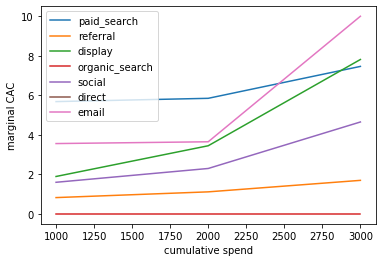

In [99]:
for channel in channels:
    # get channel data
    channel_data = df_CAC.loc[channel]
    # structure data
    data_full = [['t1', channel_data[1], channel_data[0], channel_data[1]/channel_data[0],
        channel_data[1], channel_data[0], channel_data[2]],
        ['t2', channel_data[1]+channel_data[4], channel_data[0]+channel_data[3], 
         (channel_data[1]+channel_data[4])/(channel_data[0]+channel_data[3]),
        channel_data[4], channel_data[3], channel_data[5]],
        ['t3', channel_data[1]+channel_data[4]+channel_data[7], 
         channel_data[0]+channel_data[3]+channel_data[6], 
         (channel_data[1]+channel_data[4]+channel_data[7])/(channel_data[0]+channel_data[3]+channel_data[6]),
        channel_data[7], channel_data[6], channel_data[8]]]
    # create dataframe
    channel_df = pd.DataFrame(data_full, columns = ['tier', 'cum_spend', 'cum_conversions', 'average_CAC', 
                              'marginal_spend', 'marginal_conversions', 'marginal_CAC'])
    print(channel)
    print(channel_df)
    # plot
    x = [1000, 2000, 3000]
    y = channel_df['marginal_CAC']
    plt.plot(x, y, label=channel)
    plt.xlabel('cumulative spend')
    plt.ylabel('marginal CAC')
    plt.legend()

In [101]:
df_final = pd.read_csv('model_channel_spend.csv')
df_final.head(1)

,model,channel,spend
0,last_touch_point,social,3000


In [105]:
channels = list(set(df_final['channel']))
models = list(set(df_final['model']))

In [108]:
channels

['paid_search', 'referral', 'display', 'social', 'email']

In [109]:
models

['first_touch_point', 'last_non_direct', 'last_touch_point']

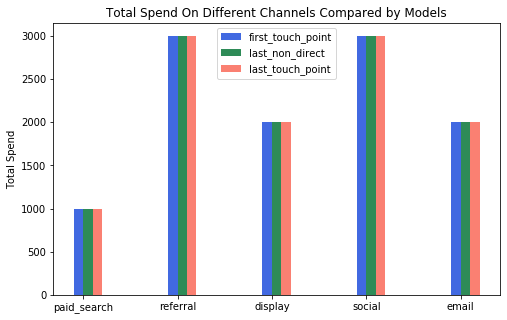

In [119]:
N = 5
ind = np.arange(N)

# x: channel
# y: spend
# category: model

# channel
channels = ['paid_search', 'referral', 'display', 'social', 'email']

# model
last_touch_point = [1000, 3000, 2000, 3000, 2000]
first_touch_point = [1000, 3000, 2000, 3000, 2000]
last_non_direct = [1000, 3000, 2000, 3000, 2000]

width = 0.10

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, first_touch_point, width, color='royalblue', label='first_touch_point')
rects2 = ax.bar(ind+width, last_non_direct, width, color='seagreen', label='last_non_direct')
rects3 = ax.bar(ind+width*2, last_touch_point, width, color='salmon', label='last_touch_point')

# add some
ax.set_ylabel('Total Spend')
ax.set_title('Total Spend On Different Channels Compared by Models')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(channels)

ax.legend()
plt.show()